<a href="https://colab.research.google.com/github/kimdesok/FinanceDataReader/blob/master/Short_Sell_Stock_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid data and its relation to the price and returns of an example stock....

##1. Setting libraries and environment
> * importing libraries for data manipulation, graphics, trend indicator calculation, etc
> * Downloading stock data and preparing them for the further processing

In [10]:
import urllib
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from urllib.request import urlopen
import seaborn as sns


In [11]:
!pip install finance-datareader

#Ta-Lib library installation for calculating trend indicators

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

import talib
import datetime

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3661    0  3661    0     0   4164      0 --:--:-- --:--:-- --:--:--  4160
100  503k  100  503k    0     0   191k      0  0:00:02  0:00:02 --:--:--  557k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3653    0  3653    0     0   3915      0 --:--:-- --:--:-- --:--:--  3915
100  406k  100  406k    0     0   154k      0  0:00:02  0:00:02 --:--:--  519k



### Downloading the stock data

In [12]:
import FinanceDataReader as fdr
from datetime import date

def short_graphs(my_file):
  short_df = pd.read_csv(my_file, encoding='cp949')

  #sort the short sell data
  short_df['Date'] = pd.to_datetime(short_df[short_df.columns[0]])
  short_df = short_df.pivot_table(index='Date', values=[short_df.columns[1], short_df.columns[4]])

  columns=[short_df.columns[0], short_df.columns[1]]
  short_df= short_df[columns]

  short_df = short_df.rename({short_df.columns[0]:'Volume', short_df.columns[1]: 'Balance'}, axis=1)

  # Set the index column and sort the short sell data
  #short_df = short_df.set_index(short_df['Date']) why not?
  short_df = short_df.sort_index()

  short_df['Balance_diff'] = short_df['Balance'].diff()
  short_df['Repay_volume'] = (short_df['Volume'] - short_df['Balance_diff']).fillna(0).rolling(5).mean()
  short_df['Balance'] =short_df['Balance'].fillna(0).rolling(5).mean()
  short_df['Volume'] = short_df['Volume'].fillna(0).rolling(5).mean()
  #Set the beginning date for the analysis
  start_date = short_df.index[0]
  #end_date = short_df.index[-1] 

  end_date = date.today()

  print('Displaying the data from ', start_date, 'to ', end_date, '\n')

  plt.figure(figsize = (10,8))

  plt.plot(short_df['Volume'], color = 'green',  label='Volume')
  plt.plot(short_df['Repay_volume'][:-2], color = 'red', label='Repay_volume')
  plt.plot(short_df['Balance'][:-2], color = 'orange', label='Balance')

  plt.xlabel('Date')
  plt.xticks(rotation=45)
  plt.ylabel('Short Data')
  plt.title(my_file)
  plt.legend()
  plt.grid(True)
  plt.show()  # show the plot

  return short_df

In [30]:
def stock_graphs(Company_names, code, short_df):

    #Set the beginning date for the analysis
    start_date = short_df.index[0]
    #end_date = short_df.index[-1] 
    end_date = date.today()
    print('Displaying the data from ', start_date, 'to ', end_date, '\n')

    # Load the stock market data from start_date to today
    full_df = fdr.DataReader(code, start_date, end_date)
    print(full_df.dropna().info())

    #Data transform using the closing price
    full_df = full_df.pivot_table(index='Date', values=['Close', 'Volume'])

    key0 = Company_names['ENG']
    print(key0)
    key1, key2= short_df.columns[0], short_df.columns[1]

    #Join stock and short sell dataframes

    full_df = full_df.rename({'Close': key0}, axis=1)

    full_df[key0] = full_df[key0].fillna(0).rolling(5).mean()
    full_df['Short_interest'] = (short_df['Volume']/full_df['Volume']).fillna(0).rolling(5).mean()
  
    plt.figure(figsize = (10,8))
    plt.plot(full_df[key0]/full_df[key0].max(), color = 'black', label ='Price')
    plt.plot(short_df[key1]/short_df[key1].max(), color = 'green', label=key1, alpha=0.5)
    plt.plot(short_df[key2][:-2]/short_df[key2][:-2].max(), color = 'orange', label=key2, alpha=0.5)
    plt.plot(full_df['Short_interest'], color = 'red', label='Short_interest', alpha=0.5)

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Fractional Change')
    plt.title(key0 +': Relation between the price and short sells')
    plt.legend()
    plt.grid(True)

    plt.show()  # show the plot

    plt.clf()  # clear the plot space

def get_codes(my_file, names):
  df = pd.read_csv(my_file)
  code_list = {}
  for name in names:
    code = df.query("names=='{}'".format(name))['codes'].to_string(index=False)
    code = code.strip()
    code_list[name] = code
  return code_list

##2. Brief EDA
> * Calculate the correlation between the price and the short volume and balance

SK바이오사이언스 302440
Displaying the data from  2021-07-28 00:00:00 to  2022-02-02 



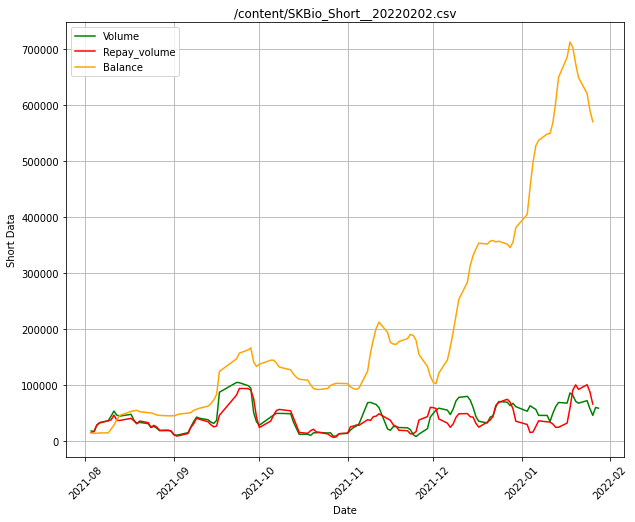

Displaying the data from  2021-07-28 00:00:00 to  2022-02-02 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126 entries, 2021-07-28 to 2022-01-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    126 non-null    int64  
 1   High    126 non-null    int64  
 2   Low     126 non-null    int64  
 3   Close   126 non-null    int64  
 4   Volume  126 non-null    int64  
 5   Change  126 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 6.9 KB
None
SK Bioscience


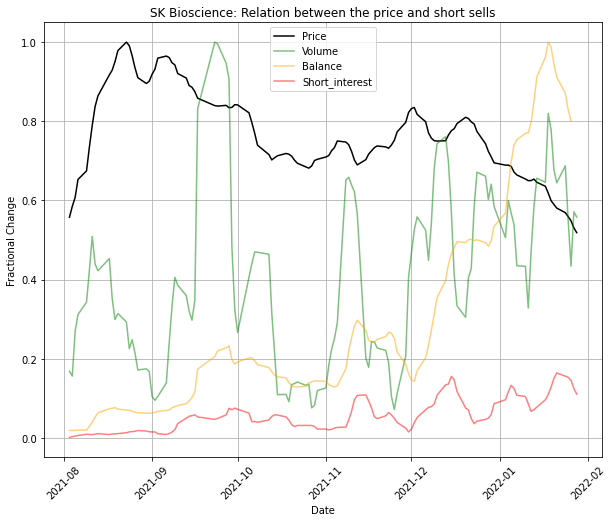

씨젠 96530
HK이노엔 195940
Displaying the data from  2021-08-09 00:00:00 to  2022-02-02 



<Figure size 432x288 with 0 Axes>

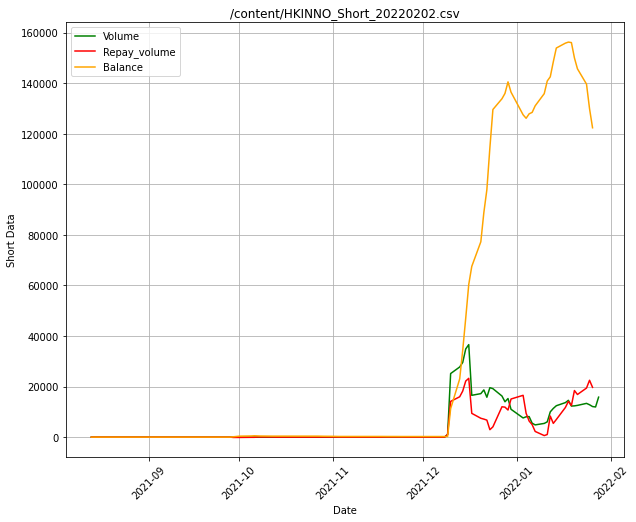

Displaying the data from  2021-08-09 00:00:00 to  2022-02-02 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2021-08-10 to 2022-01-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    117 non-null    int64  
 1   High    117 non-null    int64  
 2   Low     117 non-null    int64  
 3   Close   117 non-null    int64  
 4   Volume  117 non-null    int64  
 5   Change  117 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 6.4 KB
None
HK InnoN


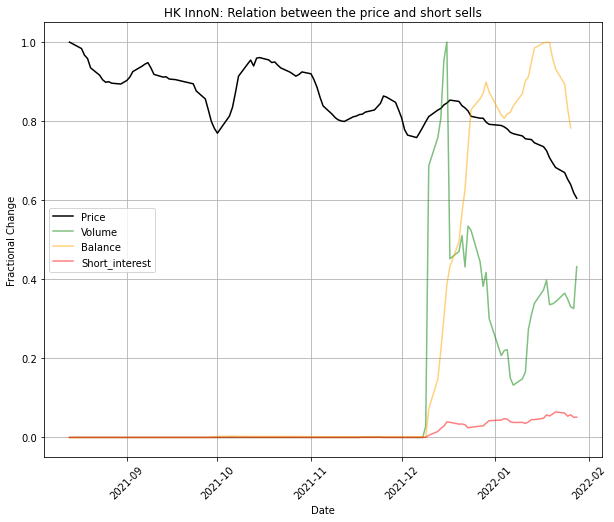

<Figure size 432x288 with 0 Axes>

In [38]:
#For this exercise, we need dataframes representing the stock perfromance of many companies.
Company_names = {'SK바이오사이언스':'SK Bioscience', '씨젠':'Seegene', '피씨엘':'PCL', '프레스티지바이오파마':'Prestige Biopharma', \
                '삼성전자':'Samsung','셀트리온':'Celltrion', '현대차':'Hyundai Automobile', \
                '대한항공':'Korean Air', '호텔신라':'Hotel Shilla', 'HK이노엔':'HK InnoN'}

my_codes = '/content/drive/MyDrive/datasets/stock_codes.csv'
code_list = get_codes(my_codes, Company_names)

Company_names = {'KOR':'SK바이오사이언스','ENG': 'SK Bioscience'}
code = code_list[Company_names['KOR']]
print(Company_names['KOR'], code)
my_file = '/content/SKBio_Short__20220202.csv'
short_df=short_graphs(my_file)
stock_graphs(Company_names, code, short_df)

Company_names = {'KOR':'씨젠', 'ENG':'Seegene'}
code = code_list[Company_names['KOR']]
print(Company_names['KOR'], code)
my_file = '/content/SeeGene_Short_20220202.csv'
#short_df=short_graphs(my_file)
#stock_graphs(Company_names, code, short_df)

Company_names = {'KOR':'HK이노엔', 'ENG':'HK InnoN'}
code = code_list[Company_names['KOR']]
print(Company_names['KOR'], code)
my_file = '/content/HKINNO_Short_20220202.csv'
short_df=short_graphs(my_file)
stock_graphs(Company_names, code, short_df)
